In [96]:
import json, re, string, datetime, tweepy, requests
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import nltk, gensim, tqdm
from bs4 import BeautifulSoup
from tabulate import tabulate
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from requests_oauthlib import OAuth1
from urllib.request import urlopen

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [99]:
df_test = pd.read_csv('umk_tweets_202112_clean.csv')
df_test = df_test.head(100)

In [101]:
df_train = pd.read_csv('dataset_komentar_instagram_cyberbullying.csv')
df_train.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [102]:
df_test.shape

(100, 9)

In [103]:
df_train.shape

(400, 3)

# Pre Processing

In [104]:
df_train.rename(columns={"Instagram Comment Text":"content"}, inplace=True)
df_train.drop(columns=["Id"],inplace=True,)
df_train.replace({"Sentiment":{"negative":0, "positive":1}}, inplace=True)
df_test.drop(columns=["Unnamed: 0"],inplace=True,)

In [105]:
df_train.head()

,Sentiment,content
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,0,Geblek lo tata...cowo bgt dibela2in balikan......
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [106]:
def casefolding(text):
  # lower case
  text = text.lower()

  # menghilangkan tag, tautan, dan angka
  text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^A-Za-z \t])|(\w+:\/\/\S+)|(\d+)", " ", text).split())

  # menghilangkan tanda baca
  text = text.translate(str.maketrans("","",string.punctuation))

  # Menghilangkan whitespaces
  text = text.strip()

  return text

In [107]:
df_train['clean'] = df_train['content'].apply(casefolding)
df_test['clean'] = df_test['content'].apply(casefolding)

In [108]:
def remove_emojis(teks):
    pola_emoji = re.compile(
        "["
        "\U0001F600-\U0001F64F"  # Emotikon
        "\U0001F300-\U0001F5FF"  # Simbol dan Piktograf Lainnya
        "\U0001F680-\U0001F6FF"  # Simbol Transportasi & Peta
        "\U0001F700-\U0001F77F"  # Pelengkap Alfanumerik
        "\U0001F780-\U0001F7FF"  # Bentuk Geometri yang Diperpanjang
        "\U0001F800-\U0001F8FF"  # Panah Pelengkap-C
        "\U0001F900-\U0001F9FF"  # Simbol dan Piktograf Pelengkap
        "\U0001FA00-\U0001FA6F"  # Simbol Catur
        "\U0001FA70-\U0001FAFF"  # Simbol dan Piktograf Diperpanjang-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )

    teks_tanpa_emoji = pola_emoji.sub(r"", teks)

    return teks_tanpa_emoji

In [109]:
df_train['clean'] = df_train['clean'].apply(remove_emojis)
df_test['clean'] = df_test['clean'].apply(remove_emojis)

In [110]:
EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

In [111]:
def remove_emoticons(text):
    emoticon_pattern = re.compile(u'(' + u'|'.join(k for k in EMOTICONS) + u')')
    return emoticon_pattern.sub(r'', text)

In [112]:
df_train['clean'] = df_train['clean'].apply(remove_emoticons)
df_test['clean'] = df_test['clean'].apply(remove_emoticons)

In [113]:
!pip install indoNLP

In [114]:
from indoNLP.preprocessing import replace_slang, replace_word_elongation, remove_stopwords

In [115]:
def replace_slang_func(text):
    clean = replace_slang(text)
    return clean

In [116]:
df_train['clean'] = df_train['clean'].apply(replace_slang_func)
df_test['clean'] = df_test['clean'].apply(replace_slang_func)

In [117]:
def replace_word_elongation_func(text):
    clean = replace_word_elongation(text)
    return clean

In [118]:
df_train['clean'] = df_train['clean'].apply(replace_word_elongation_func)
df_test['clean'] = df_test['clean'].apply(replace_word_elongation_func)

In [150]:
add_sw = [
    "ya",
    "nya",
    "banget",
    "username",
    "sih",
    "kalo",
    "kayak",
    "gue",
    "deh",
    "lo",
    "lu",
    "tau",
    "biar",
    "nih",
    "sok",
    "n",
    "nah",
    "mah",
    "tuh",
    "en",
    "at",
    "eh",
    "an"
]

In [151]:
def remove_stopword(text):
    stop_words = stopwords.words('indonesian')
    stop_words.extend(add_sw)
    stop_words = set(stop_words)
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return remove_stopwords(text)

In [152]:
df_train['clean'] = df_train['clean'].apply(remove_stopword)
df_test['clean'] = df_test['clean'].apply(remove_stopword)

In [153]:
def tokenise(text):
    words = word_tokenize(text)
    return words

In [154]:
df_train['tokenized'] = df_train['clean'].apply(tokenise)
df_test['tokenized'] = df_test['clean'].apply(tokenise)

In [155]:
df_train.head()

,Sentiment,content,clean,tokenized
0,0,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...,tolol hubungan keguguran pakai hijab syar i bi...,"[tolol, hubungan, keguguran, pakai, hijab, sya..."
1,0,Geblek lo tata...cowo bgt dibela2in balikan......,geblek tata cowok dibela balikan hadew entar d...,"[geblek, tata, cowok, dibela, balikan, hadew, ..."
2,0,Kmrn termewek2 skr lengket lg duhhh kok labil ...,kemarin termewek lengket duh labil mbak kaya a...,"[kemarin, termewek, lengket, duh, labil, mbak,..."
3,0,"Intinya kalau kesel dengan ATT nya, gausah ke ...",intinya kesel anaknya kasihan perkembangan psi...,"[intinya, kesel, anaknya, kasihan, perkembanga..."
4,0,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha...",hadew permpuan sakit jiwa peran utama film han...,"[hadew, permpuan, sakit, jiwa, peran, utama, f..."


In [156]:
df_test.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,clean,tokenized,Sentiment
0,c4f79594-78cd-48d5-876f-ef864d13657a,Memudahkan saya untuk melakukan transaksi apapun,5,0,2.35.0,1/31/2023 23:59,NaN,NaN,memudahkan transaksi apapun,"[memudahkan, transaksi, apapun]",1
1,88754df5-86f1-42f7-ba5d-a9ca5df6c1e6,Mantap,5,0,2.35.0,1/31/2023 23:59,NaN,NaN,mantap,[mantap],1
2,8f5ca792-d4f2-4ea9-9c9f-6720bc3e942c,Aplikasi nya sangat membantu segala bentuk tra...,5,0,NaN,1/31/2023 23:59,NaN,NaN,aplikasi membantu bentuk transaksi mantap,"[aplikasi, membantu, bentuk, transaksi, mantap]",0
3,0297f1bd-2dc9-4509-9c72-f1801964fb87,simpel cepat. ga repot,5,0,2.31.0,1/31/2023 23:58,NaN,NaN,simpel cepat repot,"[simpel, cepat, repot]",0
4,72617e6a-048b-42cd-bce3-c526a4afe9a5,bagus,5,0,2.35.0,1/31/2023 23:55,NaN,NaN,bagus,[bagus],1


# Analisis Teks

In [157]:
def calculate_frequency_distribution(df):
    words = [word for words in df['tokenized'] for word in words]
    fqdist = FreqDist(words)
    return fqdist

In [158]:
fqdist_train = calculate_frequency_distribution(df_train)
top_50 = fqdist_train.most_common(50)
top_50

[('orang', 111),
 ('mbak', 66),
 ('anak', 59),
 ('semoga', 51),
 ('cantik', 49),
 ('artis', 43),
 ('suka', 37),
 ('laki', 29),
 ('keluarga', 28),
 ('keren', 28),
 ('pakai', 26),
 ('suami', 26),
 ('allah', 26),
 ('bagus', 25),
 ('bilang', 23),
 ('pelakor', 23),
 ('ganteng', 23),
 ('istri', 22),
 ('manusia', 21),
 ('nikah', 20),
 ('lihat', 20),
 ('ayu', 19),
 ('suaranya', 19),
 ('perempuan', 19),
 ('kali', 18),
 ('sehat', 18),
 ('anaknya', 17),
 ('becus', 17),
 ('dasar', 17),
 ('dunia', 16),
 ('bego', 15),
 ('otak', 14),
 ('bikin', 14),
 ('jijik', 14),
 ('bahagia', 14),
 ('cowok', 13),
 ('malu', 13),
 ('mukanya', 13),
 ('pengin', 13),
 ('amin', 13),
 ('aurel', 13),
 ('an', 12),
 ('indonesia', 12),
 ('cewek', 12),
 ('eh', 12),
 ('jelek', 12),
 ('kampungan', 12),
 ('kak', 12),
 ('jevin', 12),
 ('jaman', 11)]

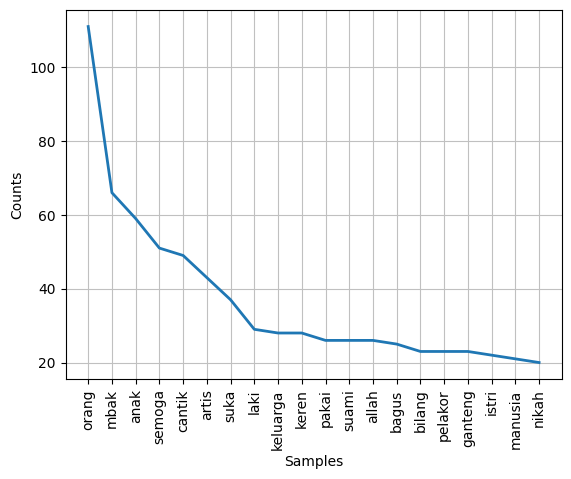

In [159]:
fqdist_train = calculate_frequency_distribution(df_train)
fqdist_train.plot(20,cumulative=False)
plt.show()

In [160]:
fqdist_test = calculate_frequency_distribution(df_test)
top_50 = fqdist_test.most_common(50)
top_50

[('bagus', 35),
 ('membantu', 12),
 ('mantap', 11),
 ('mudah', 11),
 ('aplikasi', 9),
 ('brimo', 9),
 ('gagal', 7),
 ('transaksi', 6),
 ('apk', 5),
 ('sms', 5),
 ('cepat', 4),
 ('tolong', 4),
 ('bri', 4),
 ('memudahkan', 3),
 ('simpel', 3),
 ('kali', 3),
 ('praktis', 3),
 ('saldo', 3),
 ('istri', 3),
 ('akun', 3),
 ('fidio', 3),
 ('limit', 3),
 ('bikin', 3),
 ('susah', 2),
 ('kasih', 2),
 ('mulu', 2),
 ('baguse', 2),
 ('semoga', 2),
 ('komplit', 2),
 ('error', 2),
 ('ribet', 2),
 ('ngulang', 2),
 ('pbaguso', 2),
 ('top', 2),
 ('terbantu', 2),
 ('disuruh', 2),
 ('mesin', 2),
 ('dana', 2),
 ('pusat', 2),
 ('proses', 2),
 ('mempermudah', 2),
 ('berimo', 2),
 ('persulit', 2),
 ('pas', 2),
 ('min', 2),
 ('berkurang', 2),
 ('lita', 2),
 ('mintak', 2),
 ('kode', 2),
 ('uang', 2)]

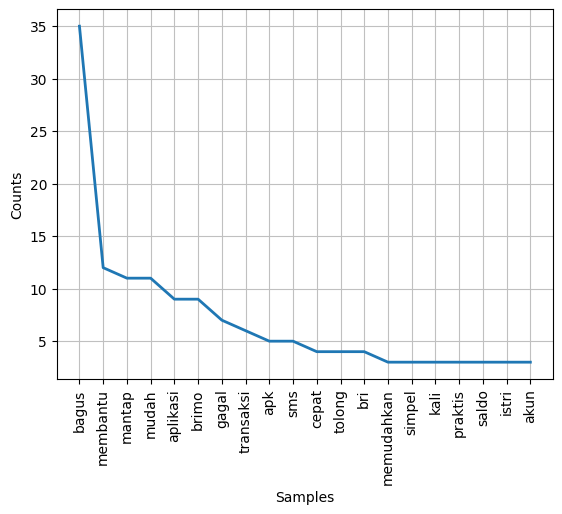

In [161]:
fqdist_test = calculate_frequency_distribution(df_test)
fqdist_test.plot(20,cumulative=False)
plt.show()

# Analisis Data Train

In [162]:
df_neg = df_train[df_train['Sentiment'] == 0]

In [163]:
fqdist_neg = calculate_frequency_distribution(df_neg)
top_50 = fqdist_neg.most_common(50)
top_50

[('orang', 92),
 ('artis', 29),
 ('anak', 27),
 ('pelakor', 23),
 ('laki', 21),
 ('pakai', 19),
 ('mbak', 19),
 ('becus', 17),
 ('perempuan', 17),
 ('bilang', 15),
 ('ayu', 15),
 ('bego', 15),
 ('dasar', 15),
 ('lihat', 15),
 ('otak', 14),
 ('manusia', 14),
 ('suami', 14),
 ('jijik', 14),
 ('kali', 12),
 ('kampungan', 12),
 ('cowok', 11),
 ('suka', 11),
 ('nikah', 11),
 ('eh', 11),
 ('malu', 11),
 ('jelek', 11),
 ('anaknya', 10),
 ('bikin', 10),
 ('lonte', 10),
 ('iya', 9),
 ('banci', 9),
 ('mukanya', 9),
 ('pengin', 9),
 ('istri', 9),
 ('kasihan', 8),
 ('bodoh', 8),
 ('buruk', 8),
 ('cewek', 8),
 ('micin', 8),
 ('gua', 8),
 ('mengomong', 8),
 ('nagita', 8),
 ('laku', 8),
 ('via', 8),
 ('enji', 8),
 ('tolol', 7),
 ('balajaer', 7),
 ('sah', 7),
 ('situ', 7),
 ('anjing', 7)]

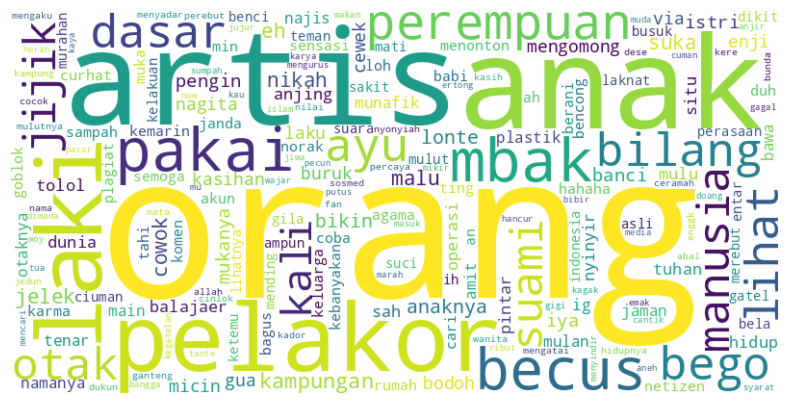

In [164]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fqdist_neg)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [165]:
df_pos = df_train[df_train['Sentiment'] == 1]

In [166]:
fqdist_pos = calculate_frequency_distribution(df_pos)
top_50 = fqdist_pos.most_common(50)
top_50

[('mbak', 47),
 ('semoga', 46),
 ('cantik', 46),
 ('anak', 32),
 ('keren', 28),
 ('suka', 26),
 ('keluarga', 23),
 ('allah', 22),
 ('bagus', 20),
 ('orang', 19),
 ('ganteng', 19),
 ('sehat', 17),
 ('suaranya', 17),
 ('artis', 14),
 ('amin', 13),
 ('istri', 13),
 ('aurel', 13),
 ('bahagia', 12),
 ('suami', 12),
 ('jevin', 12),
 ('kak', 11),
 ('sayang', 9),
 ('nikah', 9),
 ('salut', 9),
 ('dunia', 9),
 ('pasangan', 8),
 ('bilang', 8),
 ('muda', 8),
 ('laki', 8),
 ('salam', 8),
 ('indonesia', 8),
 ('sukses', 8),
 ('bu', 8),
 ('enak', 8),
 ('rini', 8),
 ('lagu', 7),
 ('jodoh', 7),
 ('manusia', 7),
 ('bangga', 7),
 ('lancar', 7),
 ('bpk', 7),
 ('kasih', 7),
 ('langsung', 7),
 ('pakai', 7),
 ('an', 7),
 ('yes', 7),
 ('pas', 7),
 ('langgeng', 7),
 ('anaknya', 7),
 ('depe', 7)]

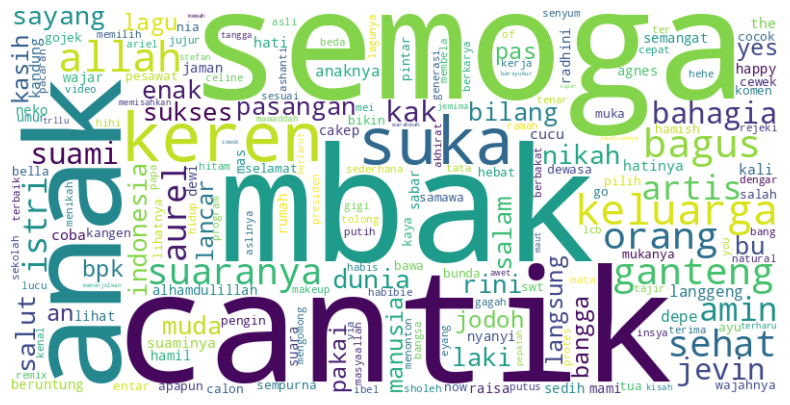

In [167]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fqdist_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Pemodelan

In [168]:
vectorizer = TfidfVectorizer(max_features=2500)
model_g = GaussianNB()

In [169]:
X = vectorizer.fit_transform(df_train['clean']).toarray()
y = df_train['Sentiment']

In [170]:
from collections import Counter

counter_y = Counter(y)
print(counter_y)

Counter({0: 200, 1: 200})


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=18)
model_g.fit(X_train,y_train)

GaussianNB()

In [172]:
y_preds = model_g.predict(X_test)

print(confusion_matrix(y_test,y_preds))
print(classification_report(y_test,y_preds))
print('nilai akurasinya adalah ',accuracy_score(y_test, y_preds))

[[33  9]
 [ 1 37]]
              precision    recall  f1-score   support

           0       0.97      0.79      0.87        42
           1       0.80      0.97      0.88        38

    accuracy                           0.88        80
   macro avg       0.89      0.88      0.87        80
weighted avg       0.89      0.88      0.87        80

nilai akurasinya adalah  0.875


In [173]:
test = vectorizer.transform(df_test["clean"]).toarray()
y_classification = model_g.predict(test)

df_test["Sentiment"] = list(y_classification)

In [174]:
df_test.head()

,reviewId,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,clean,tokenized,Sentiment
0,c4f79594-78cd-48d5-876f-ef864d13657a,Memudahkan saya untuk melakukan transaksi apapun,5,0,2.35.0,1/31/2023 23:59,NaN,NaN,memudahkan transaksi apapun,"[memudahkan, transaksi, apapun]",1
1,88754df5-86f1-42f7-ba5d-a9ca5df6c1e6,Mantap,5,0,2.35.0,1/31/2023 23:59,NaN,NaN,mantap,[mantap],1
2,8f5ca792-d4f2-4ea9-9c9f-6720bc3e942c,Aplikasi nya sangat membantu segala bentuk tra...,5,0,NaN,1/31/2023 23:59,NaN,NaN,aplikasi membantu bentuk transaksi mantap,"[aplikasi, membantu, bentuk, transaksi, mantap]",0
3,0297f1bd-2dc9-4509-9c72-f1801964fb87,simpel cepat. ga repot,5,0,2.31.0,1/31/2023 23:58,NaN,NaN,simpel cepat repot,"[simpel, cepat, repot]",0
4,72617e6a-048b-42cd-bce3-c526a4afe9a5,bagus,5,0,2.35.0,1/31/2023 23:55,NaN,NaN,bagus,[bagus],1


# Analisis Data Test

In [175]:
df_neg = df_test[df_test['Sentiment'] == 0]

In [176]:
fqdist_neg = calculate_frequency_distribution(df_neg)
top_50 = fqdist_neg.most_common(50)
top_50

[('aplikasi', 9),
 ('mudah', 8),
 ('brimo', 7),
 ('sms', 5),
 ('membantu', 4),
 ('transaksi', 4),
 ('tolong', 4),
 ('gagal', 4),
 ('cepat', 3),
 ('apk', 3),
 ('istri', 3),
 ('akun', 3),
 ('fidio', 3),
 ('limit', 3),
 ('mulu', 2),
 ('kali', 2),
 ('ribet', 2),
 ('ngulang', 2),
 ('top', 2),
 ('disuruh', 2),
 ('bri', 2),
 ('mesin', 2),
 ('berimo', 2),
 ('persulit', 2),
 ('min', 2),
 ('berkurang', 2),
 ('lita', 2),
 ('mintak', 2),
 ('kode', 2),
 ('uang', 2),
 ('masuk', 2),
 ('menunggu', 2),
 ('link', 2),
 ('desa', 2),
 ('bentuk', 1),
 ('mantap', 1),
 ('simpel', 1),
 ('repot', 1),
 ('daftar', 1),
 ('sulit', 1),
 ('solusi', 1),
 ('nyatane', 1),
 ('menyusahkan', 1),
 ('fitur', 1),
 ('lupa', 1),
 ('password', 1),
 ('kbagus', 1),
 ('pertahankan', 1),
 ('amanan', 1),
 ('puas', 1)]

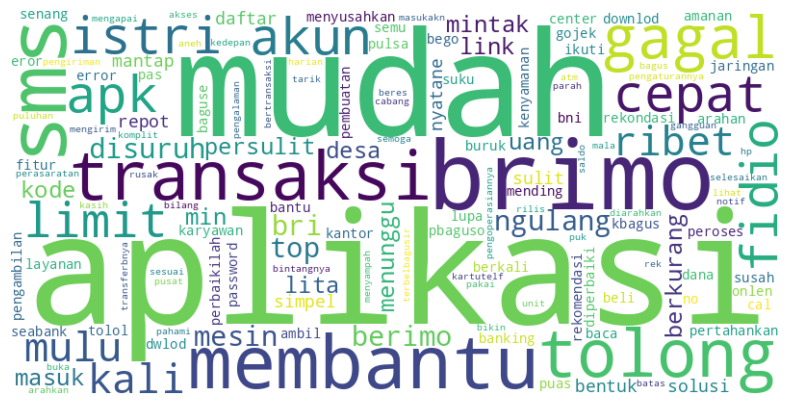

In [177]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fqdist_neg)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [178]:
df_pos = df_test[df_test['Sentiment'] == 1]

In [179]:
fqdist_pos = calculate_frequency_distribution(df_pos)
top_50 = fqdist_pos.most_common(50)
top_50

[('bagus', 34),
 ('mantap', 10),
 ('membantu', 8),
 ('memudahkan', 3),
 ('praktis', 3),
 ('mudah', 3),
 ('gagal', 3),
 ('transaksi', 2),
 ('bri', 2),
 ('simpel', 2),
 ('terbantu', 2),
 ('brimo', 2),
 ('proses', 2),
 ('saldo', 2),
 ('mempermudah', 2),
 ('apk', 2),
 ('bikin', 2),
 ('apapun', 1),
 ('sayangnya', 1),
 ('aplicasi', 1),
 ('ceria', 1),
 ('susah', 1),
 ('masuknua', 1),
 ('update', 1),
 ('coba', 1),
 ('moga', 1),
 ('lancar', 1),
 ('terimaka', 1),
 ('kasih', 1),
 ('semoga', 1),
 ('tingkat', 1),
 ('keamanannya', 1),
 ('ditingkatkan', 1),
 ('tks', 1),
 ('cepat', 1),
 ('menu', 1),
 ('komplit', 1),
 ('keuangan', 1),
 ('mantaps', 1),
 ('bermanfaaf', 1),
 ('sagat', 1),
 ('aps', 1),
 ('kendala', 1),
 ('fiturnya', 1),
 ('lengkap', 1),
 ('simply', 1),
 ('the', 1),
 ('best', 1),
 ('warnai', 1),
 ('hidup', 1)]

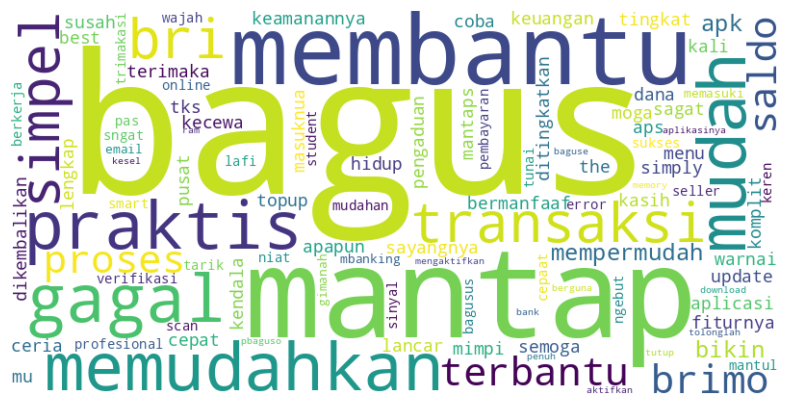

In [180]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(fqdist_pos)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()